In [1]:
from pde_nn.utils import expose_results

## Experiments run for 100K iterations, with 1K points

In [2]:
import os
top_dir = 'data/diff_sampling/'
samp_dirs = os.listdir(top_dir)

In [3]:
samp_dirs

['uniform', 'boundary', 'perturb', 'grid']

In [4]:
import numpy as np
preds=[]
for s in samp_dirs:
    for d in os.listdir(top_dir+s):
        pred = np.load(top_dir+s+'/'+d+'/preds.npy')
        preds.append(pred)

In [5]:
numerical = np.load('data/mixlen_numerical_u180.npy')

## Grid: `y=np.linspace(-1,1,1000)`

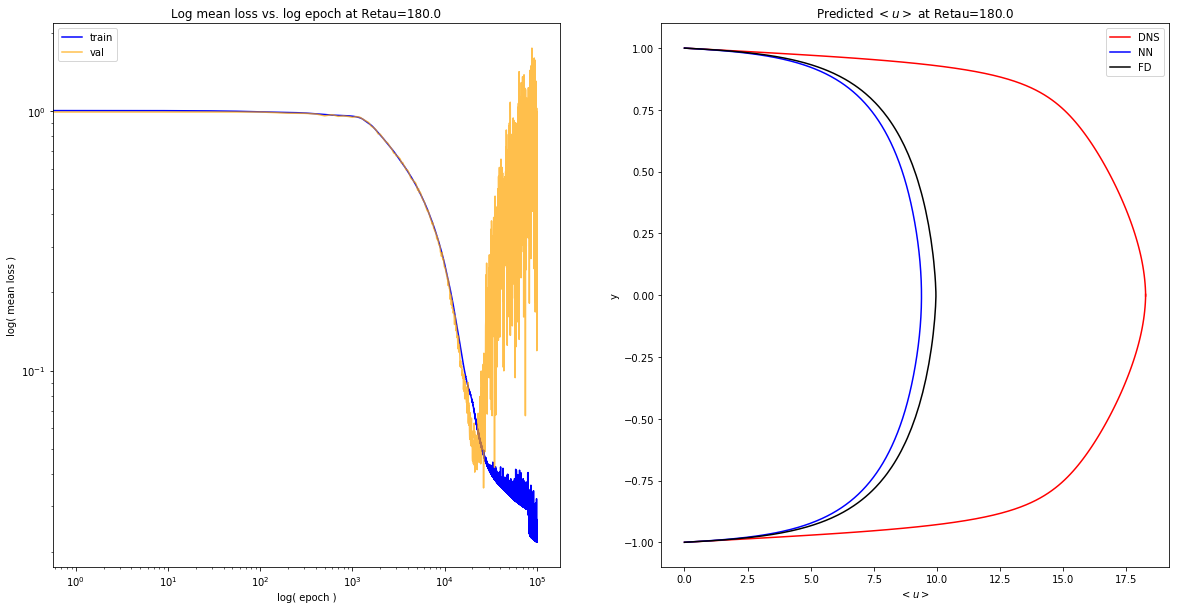

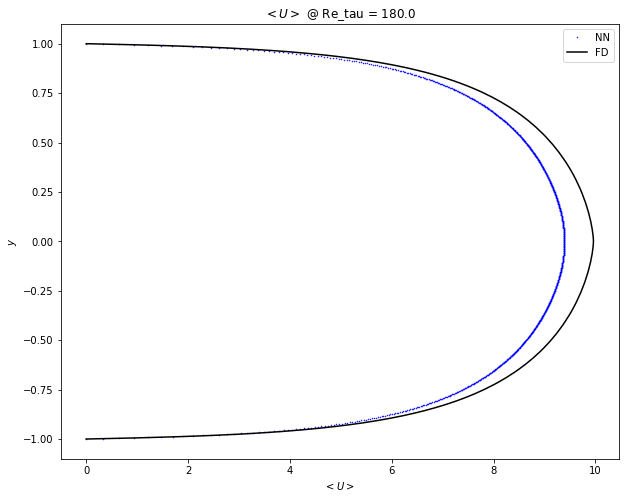

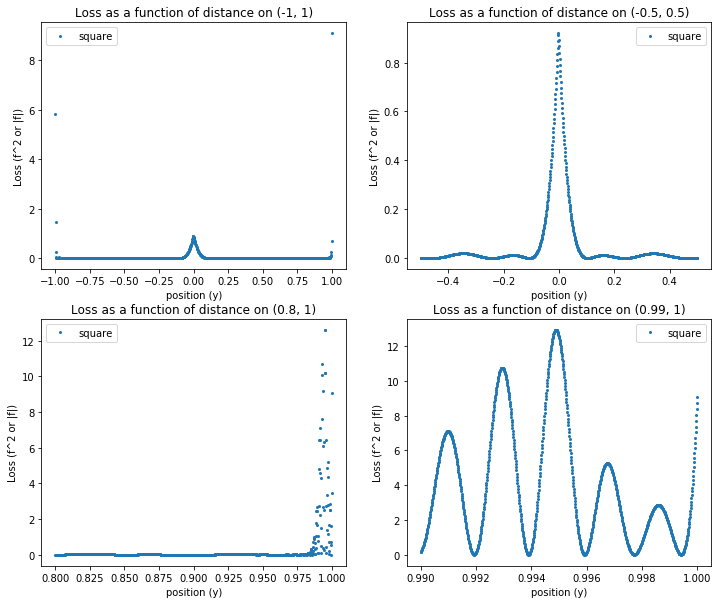

In [7]:
expose_results('diff_sampling/grid/1551391627.159183')

## Uniform: $Y \sim U(-1,1)$

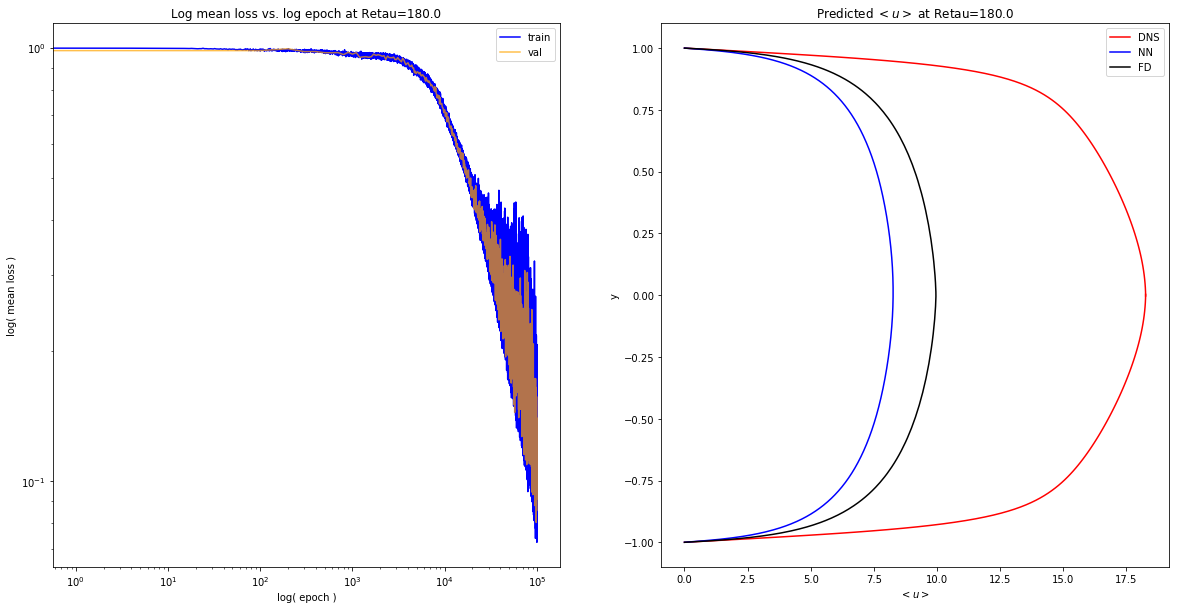

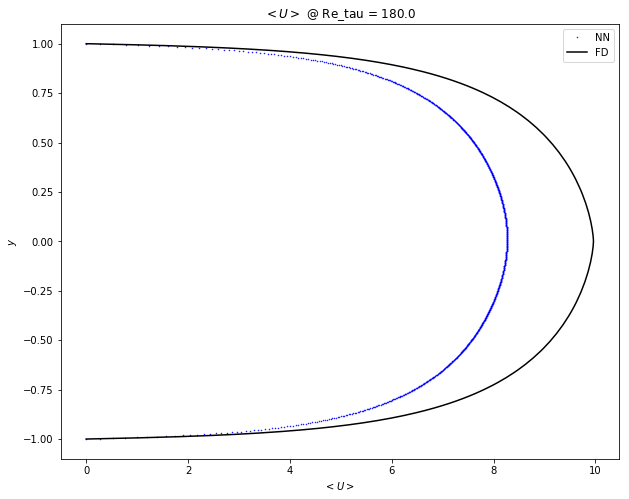

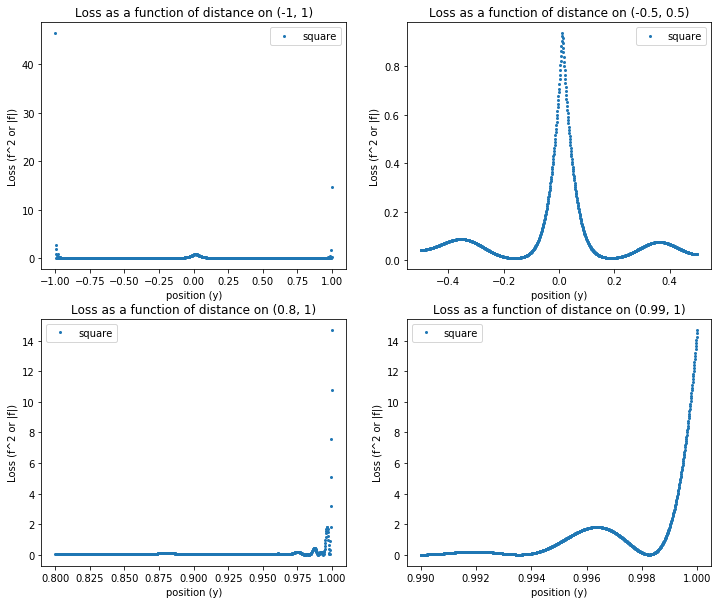

In [8]:
expose_results('diff_sampling/uniform/1551395665.506609')

## Perturbed Grid `np.linspace(-1,1)` $ + \epsilon \sim N(0,\Delta y / 3)$

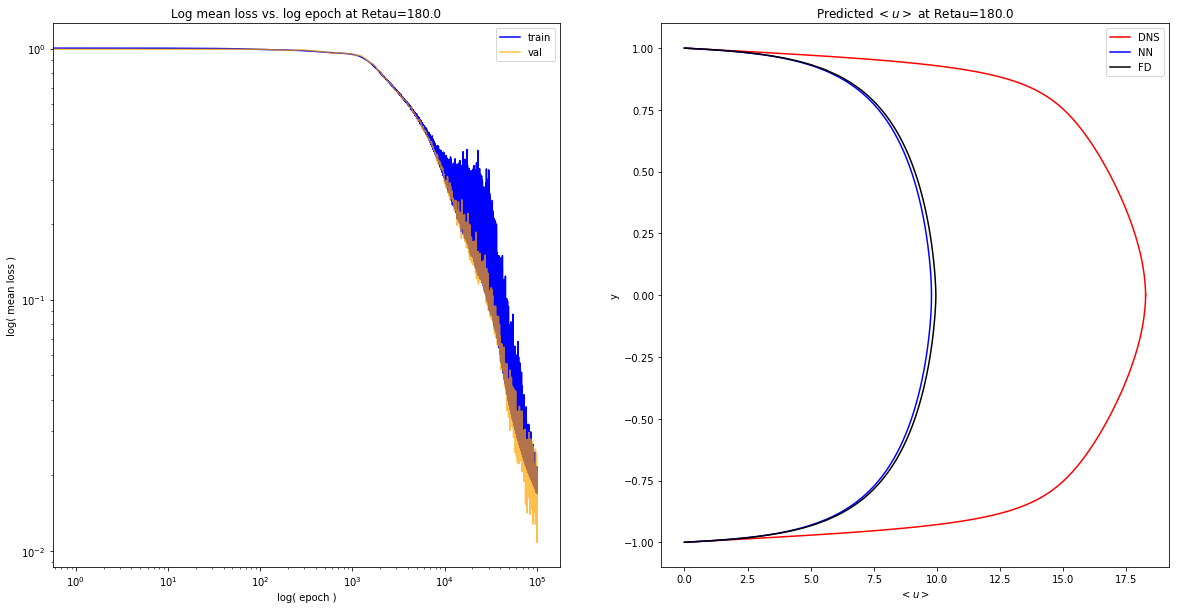

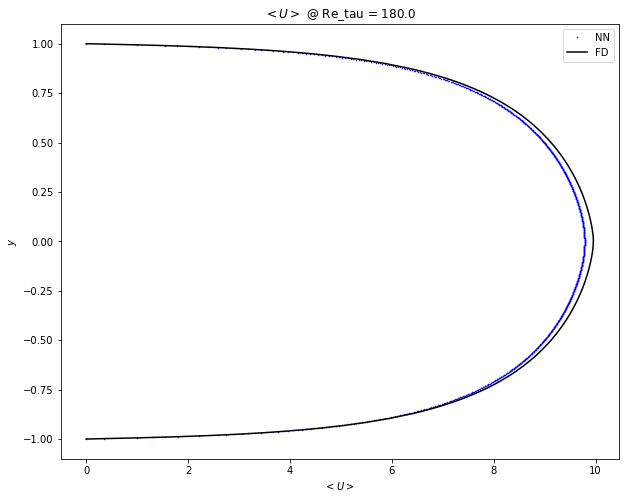

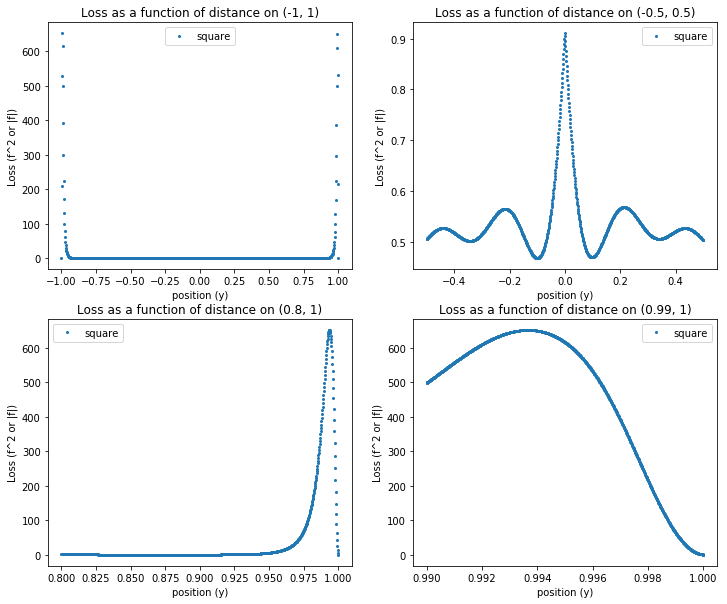

In [6]:
expose_results('diff_sampling/perturb/1551392969.8673086/')

## Log Spacing: `y=np.geomspace`

In [10]:
lhs = np.geomspace(0.02, 1, num=500) - 1.02
rhs = np.flip(-lhs, axis=0)
geomgrid = np.concatenate([lhs, rhs])

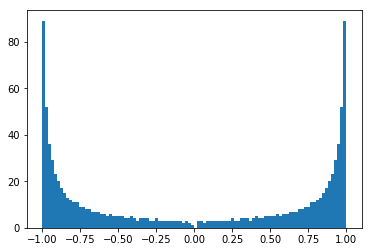

In [27]:
plt.hist(geomgrid, density=False, bins=100);

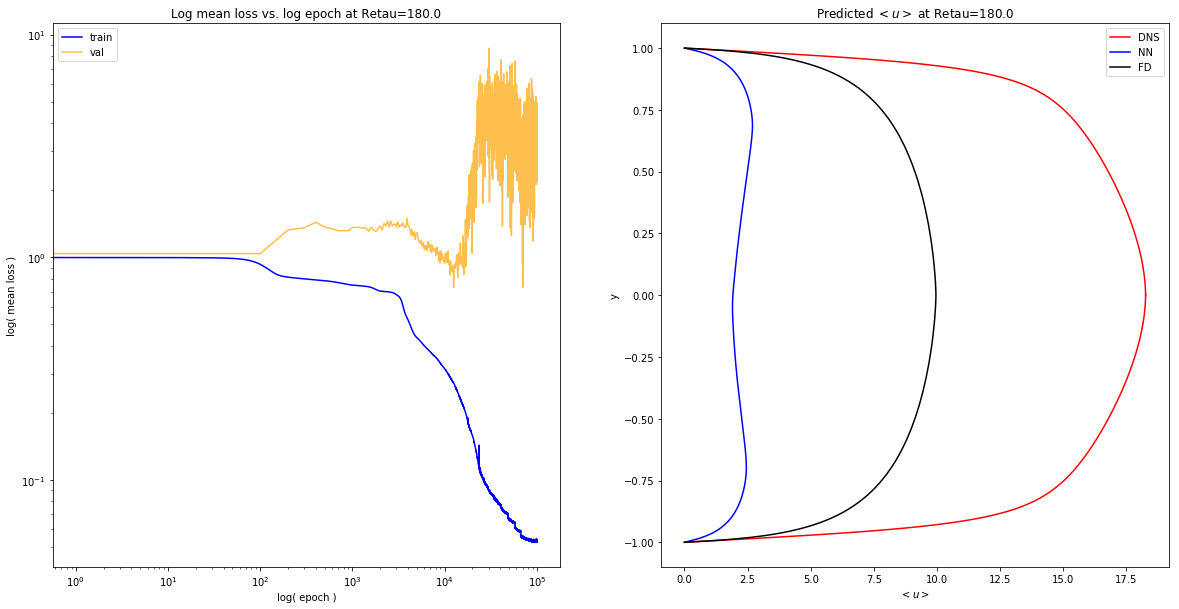

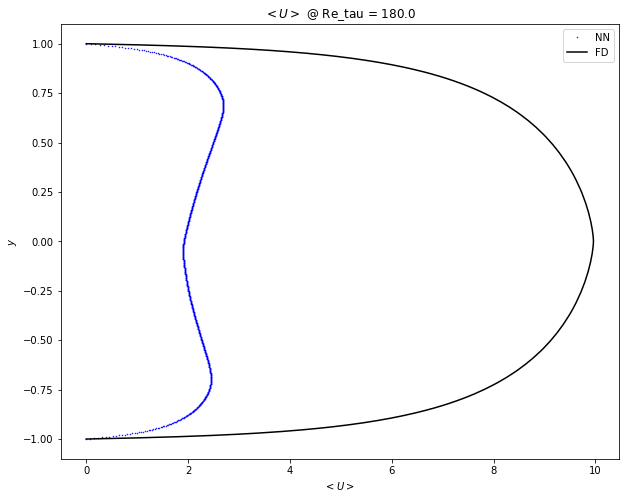

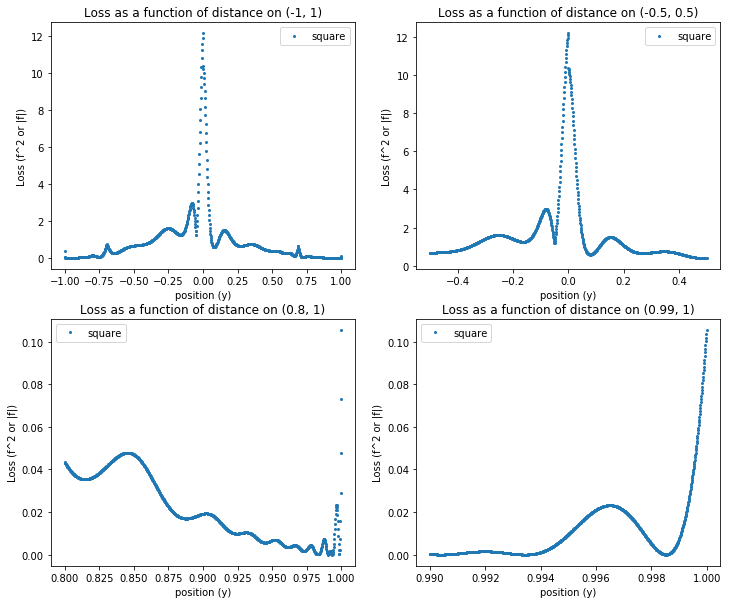

In [12]:
expose_results('diff_sampling/boundary/1551394315.400767/')

## Summary of velocity profiles

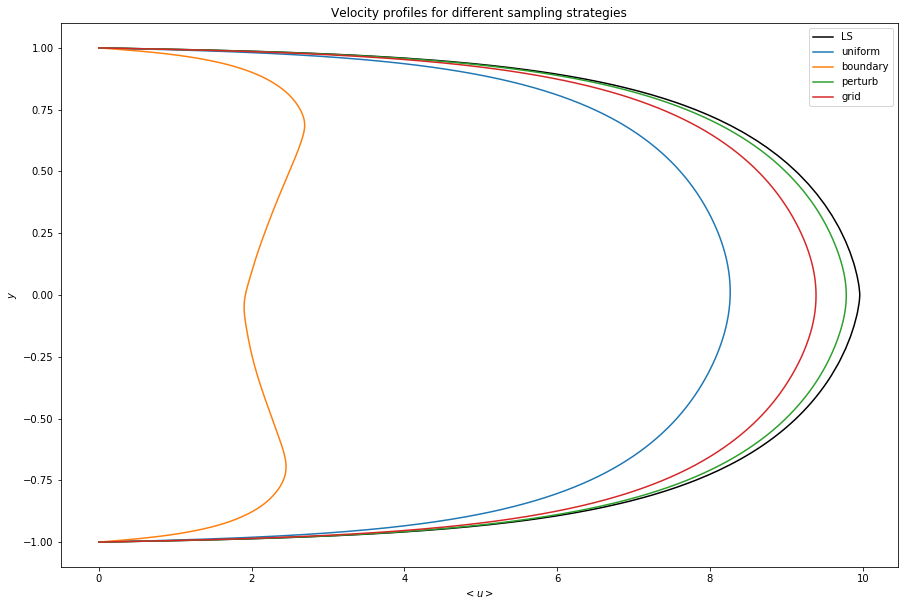

In [6]:
import matplotlib.pyplot as plt
y=np.linspace(-1,1,1000)
plt.figure(figsize=(15,10))
plt.plot(numerical, y, label='LS', color='black')
plt.title('Velocity profiles for different sampling strategies')
plt.xlabel('$< u >$')
plt.ylabel('$y$')
for i, p in enumerate(preds):
    plt.plot(p, y, label='{}'.format(samp_dirs[i]))
    plt.legend()

## Boundary Conditions on [-1,-.9]

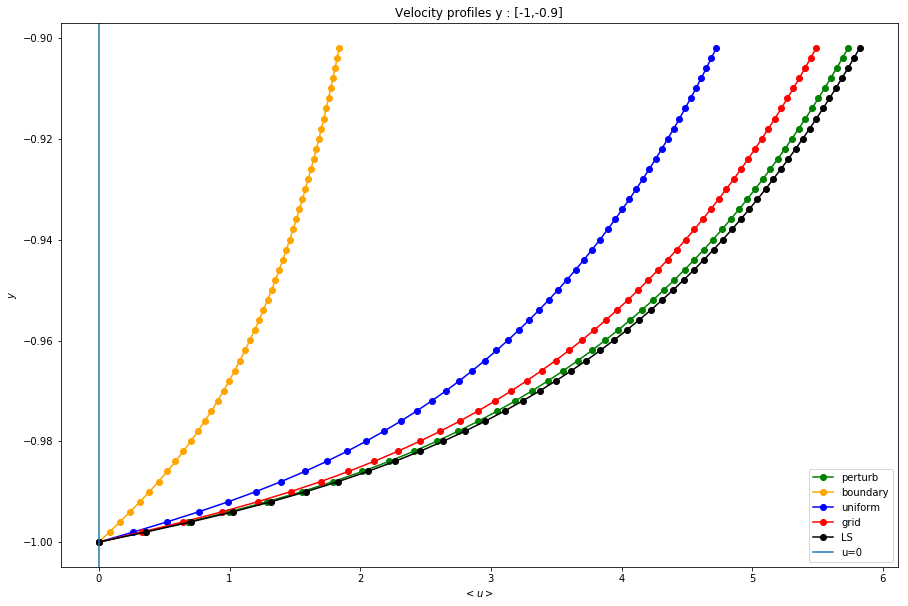

In [13]:
plt.figure(figsize=(15,10))
plt.plot(preds[2][:50], y[:50], '-o',  color='green', label='perturb')
plt.plot( preds[1][:50],y[:50], '-o',color='orange', label='boundary')
plt.plot( preds[0][:50],y[:50],'-o', color='blue', label='uniform')
plt.plot( preds[3][:50],y[:50], '-o',color='red', label='grid')
plt.plot( numerical[:50],y[:50], '-o',color='black', label='LS')
# plt.axhline(0, label='u=0')
plt.title('Velocity profiles y : [-1,-0.9]')
plt.xlabel('$<u>$')
plt.ylabel('$y$')
plt.axvline(0, label='u=0')
plt.legend();

## Boundary Conditions on [.9,1]

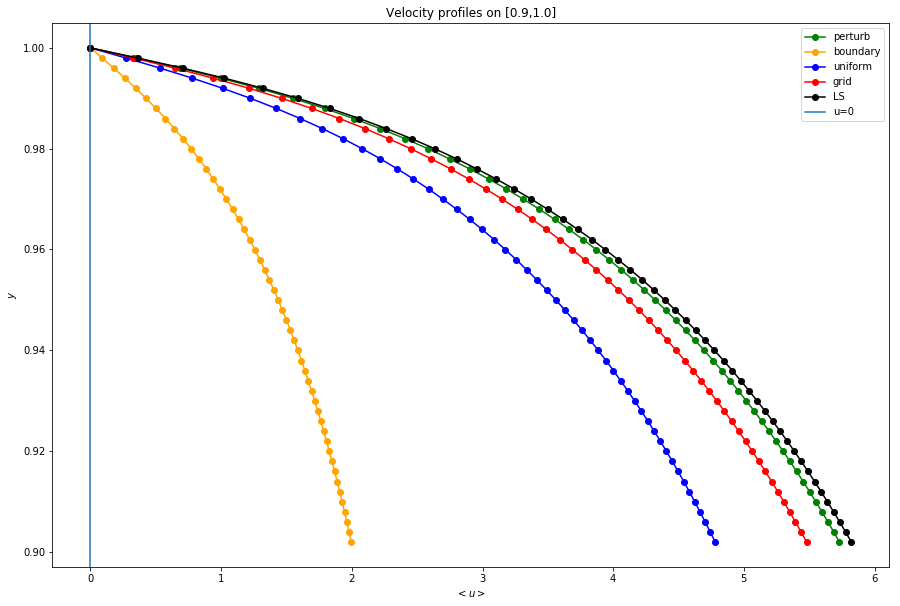

In [14]:
plt.figure(figsize=(15,10))
plt.plot(preds[2][-50:],y[-50:], '-o',  color='green', label='perturb')
plt.plot( preds[1][-50:],y[-50:], '-o', color='orange', label='boundary')
plt.plot( preds[0][-50:],y[-50:], '-o', color='blue', label='uniform')
plt.plot( preds[3][-50:],y[-50:], '-o', color='red', label='grid')
plt.plot( numerical[-50:],y[-50:], '-o', color='black', label='LS')
plt.axvline(0, label='u=0')
plt.title('Velocity profiles on [0.9,1.0]')
plt.xlabel('$<u>$')
plt.ylabel('$y$')
plt.legend();

## Boundary Conditions on [.996,1]

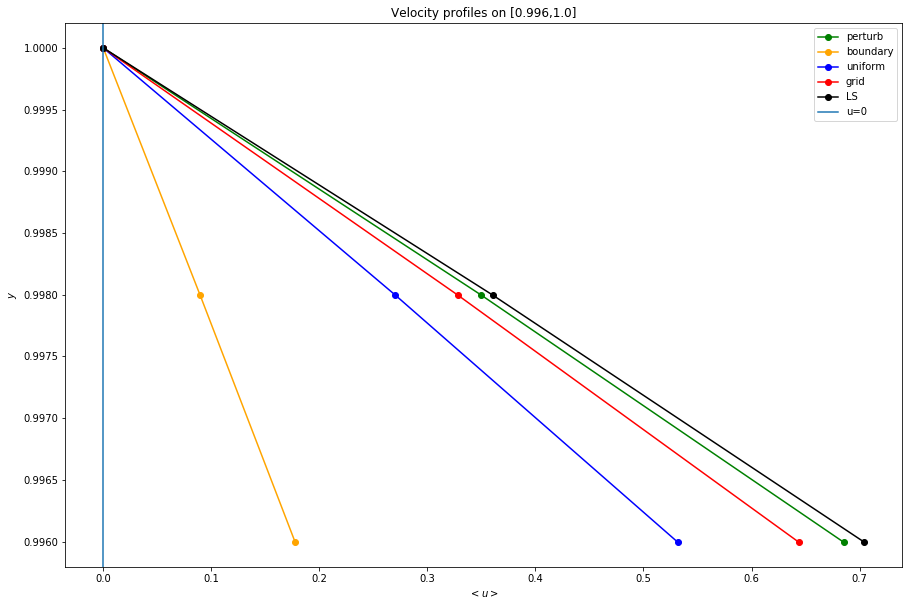

In [24]:
plt.figure(figsize=(15,10))
n=3
plt.plot(preds[2][-n:],y[-n:], '-o',  color='green', label='perturb')
plt.plot( preds[1][-n:],y[-n:], '-o', color='orange', label='boundary')
plt.plot( preds[0][-n:],y[-n:], '-o', color='blue', label='uniform')
plt.plot( preds[3][-n:],y[-n:], '-o', color='red', label='grid')
plt.plot( numerical[-n:],y[-n:], '-o', color='black', label='LS')
plt.axvline(0, label='u=0')
plt.title('Velocity profiles on [0.996,1.0]')
plt.xlabel('$<u>$')
plt.ylabel('$y$')
plt.legend();

## If BCs are satisfied, why is loss at boundary large?

In [16]:
import channel_flow as chan
import torch
from torch.autograd import grad
hypers = np.load('data/diff_sampling/perturb/1551392969.8673086/hypers.npy').item()
pdenn = chan.Chanflow(**hypers)
pdenn.load_state_dict(torch.load('data/diff_sampling/perturb/1551392969.8673086/model.pt'))

In [17]:
y_torch=torch.tensor(y.reshape(-1,1), dtype=torch.float, requires_grad=True)
u_bar= pdenn.predict(y_torch)
axial_eqn = pdenn.compute_diffeq(u_bar, y_torch)

In [18]:
# compute d(\bar{u})/dy
du_dy, = grad(u_bar, y_torch,
              grad_outputs=u_bar.data.new(u_bar.shape).fill_(1),
              retain_graph=True,
              create_graph=True)

# compute d^2(\bar{u})/dy^2
d2u_dy2, = grad(du_dy, y_torch,
                grad_outputs=du_dy.data.new(du_dy.shape).fill_(1),
                retain_graph=True,
                create_graph=True)

# compute d<uv>/dy
re = pdenn.reynolds_stress_fn(y_torch, du_dy)
dre_dy, = grad(re, y_torch,
               grad_outputs=re.data.new(re.shape).fill_(1),
               retain_graph=True,
               create_graph=True)

## $$\nu \frac{d^2u}{dy^2} - \frac{d\overline{uv}}{dy} - \frac{1}{\rho} \frac{dp}{dx} = \nu \frac{d^2u}{dy^2} - \frac{d(\kappa y)^{2} \left|\frac{du}{dy}\right| \frac{du}{dy}}{dy} - \frac{1}{\rho} \frac{dp}{dx} = 0$$

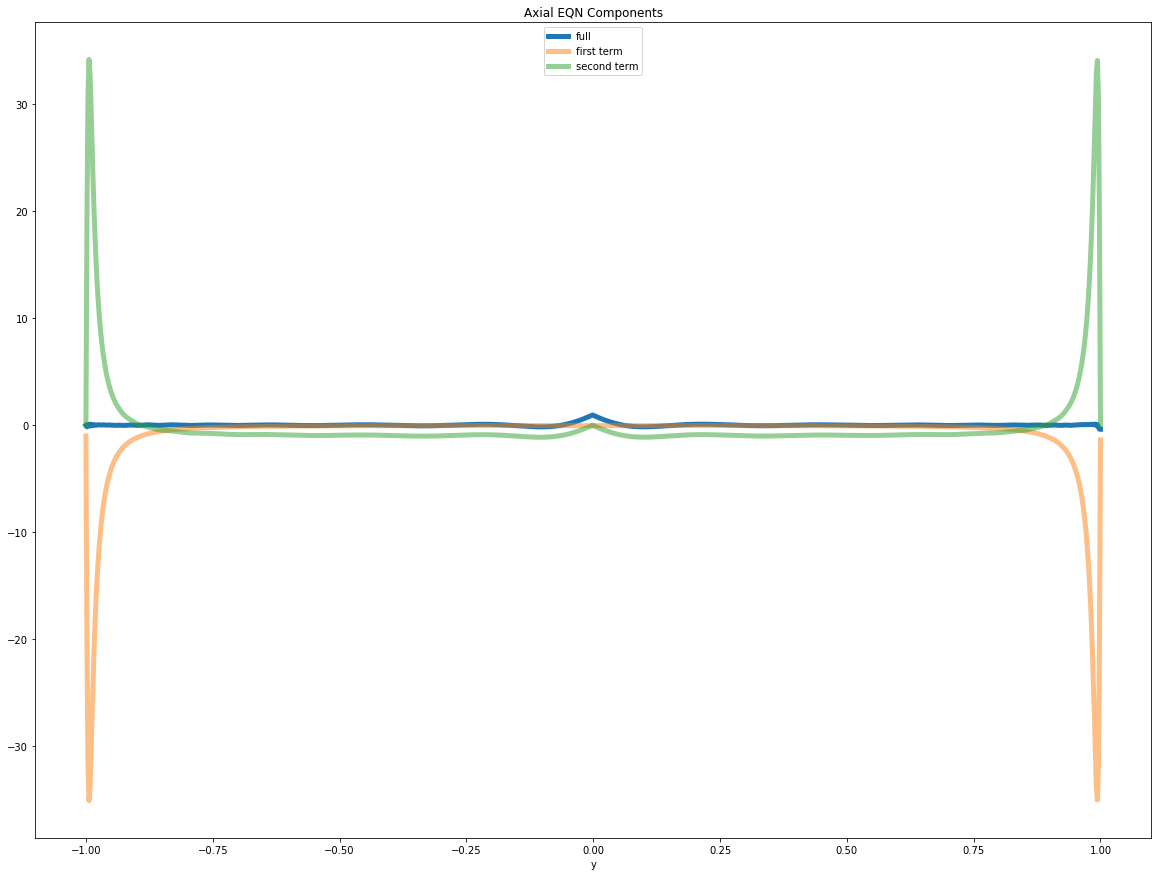

In [19]:
plt.figure(figsize=(20,15))
plt.plot(y, axial_eqn.detach().numpy(), label='full', lw=5)
# plt.plot(y, du_dy.detach().numpy(), label='first deriv')
plt.plot(y, hypers['nu']*d2u_dy2.detach().numpy(), '-', label='first term', lw=5, alpha=0.5)
plt.plot(y, -dre_dy.detach().numpy(), '-', label='second term', lw=5, alpha=0.5)
# plt.plot(y, -(1/hypers['rho'])*hypers['dp_dx']*np.ones_like(y), label='third term')
plt.xlabel('y')
plt.legend(loc='upper center')
plt.title('Axial EQN Components');

## Autograd Derivatives == Numpy Derivatives

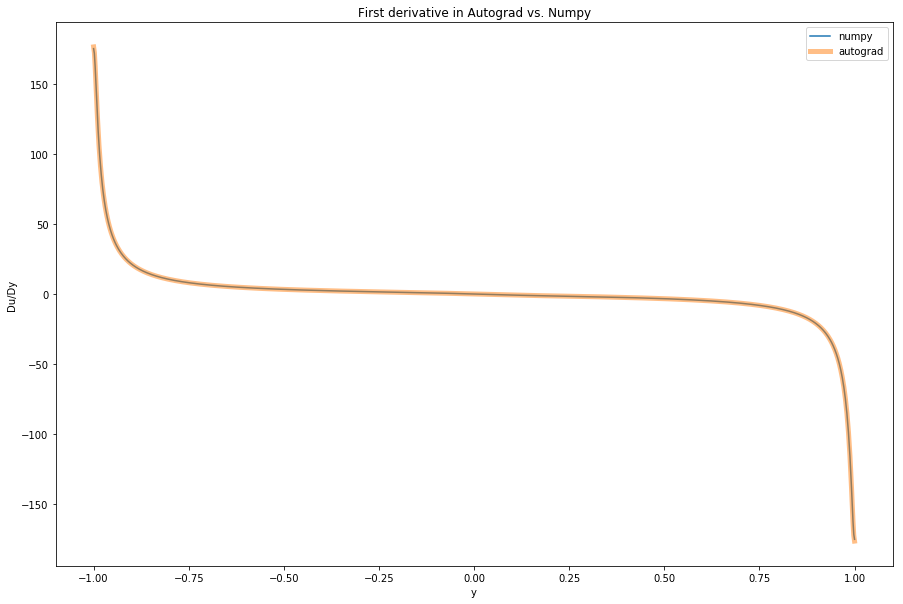

In [20]:
numerical_dudy = np.gradient(u_bar.detach().numpy()[:,0], 0.002)
plt.figure(figsize=(15,10))
plt.plot(y, numerical_dudy, '-', label='numpy', alpha=1)
plt.plot(y, du_dy.detach().numpy(), label='autograd', linewidth=5, alpha=0.5)
plt.title('First derivative in Autograd vs. Numpy')
plt.ylabel('Du/Dy')
plt.xlabel('y')
plt.legend();

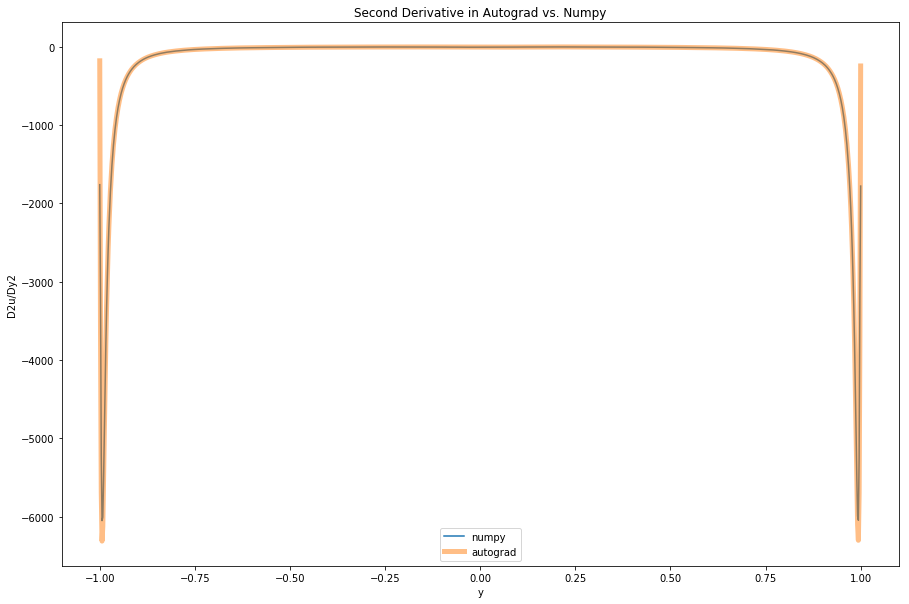

In [21]:
numerical_second_div=np.gradient(numerical_dudy, 0.002)
plt.figure(figsize=(15,10))
plt.plot(y, numerical_second_div, '-', label='numpy', alpha=1)
plt.plot(y, d2u_dy2.detach().numpy(), label='autograd', linewidth=5, alpha=0.5)
plt.title('Second Derivative in Autograd vs. Numpy')
plt.ylabel('D2u/Dy2')
plt.xlabel('y')
plt.legend();

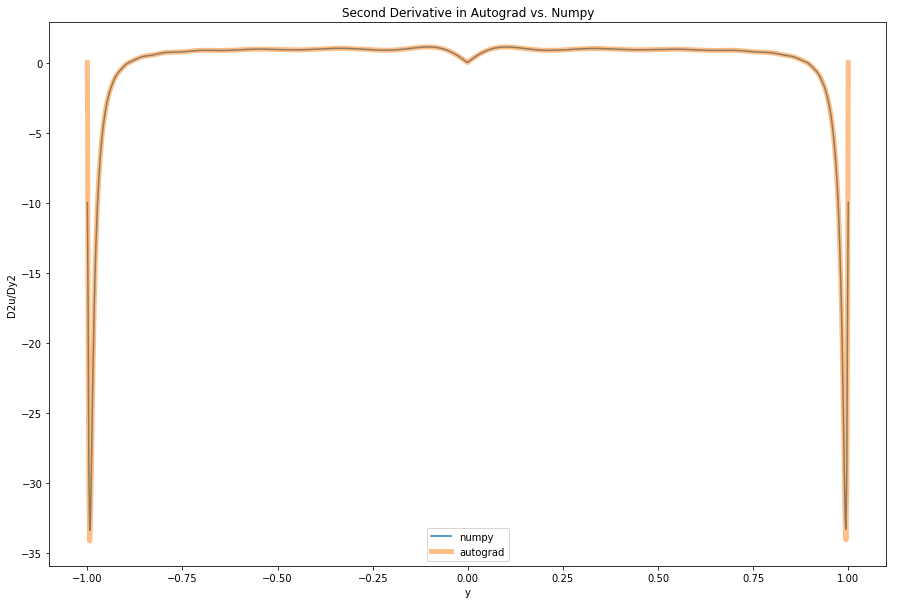

In [22]:
numerical_rediv=np.gradient(re.detach().numpy()[:,0], 0.002)
plt.figure(figsize=(15,10))
plt.plot(y, numerical_rediv, '-', label='numpy', alpha=1)
plt.plot(y, dre_dy.detach().numpy(), label='autograd', linewidth=5, alpha=0.5)
plt.title('Second Derivative in Autograd vs. Numpy')
plt.ylabel('D2u/Dy2')
plt.xlabel('y')
plt.legend();